<a href="https://colab.research.google.com/github/IvyXiaoyede/Coding3_final/blob/main/FFFFinal_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Set up environment


In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'2.12.0'

In [4]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-h0jme1ol
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-h0jme1ol
  Resolved https://github.com/tensorflow/docs to commit 82c1d10782be2714b3ece1f59c05082195474ce9
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.5.26.9808-py3-none-any.whl size=183623 sha256=ddd49a9ff2109a03c479f3c934f0e664e8283ae8f5afce8dcfdd43cb6627ebd2
  Stored in directory: /tmp/pip-ephem-wheel-cache-vxrg05bz/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [5]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
%cd /content/drive/MyDrive/Colab_Notebooks/Coding3/Flower

/content/drive/MyDrive/Colab_Notebooks/Coding3/Flower


In [8]:
!cp -av /content/drive/MyDrive/Colab_Notebooks/Coding3/Flower /content

'/content/drive/MyDrive/Colab_Notebooks/Coding3/Flower' -> '/content/Flower'
'/content/drive/MyDrive/Colab_Notebooks/Coding3/Flower/image_00013.jpg' -> '/content/Flower/image_00013.jpg'
'/content/drive/MyDrive/Colab_Notebooks/Coding3/Flower/image_00014.jpg' -> '/content/Flower/image_00014.jpg'
'/content/drive/MyDrive/Colab_Notebooks/Coding3/Flower/image_00006.jpg' -> '/content/Flower/image_00006.jpg'
'/content/drive/MyDrive/Colab_Notebooks/Coding3/Flower/image_00016.jpg' -> '/content/Flower/image_00016.jpg'
'/content/drive/MyDrive/Colab_Notebooks/Coding3/Flower/image_00026.jpg' -> '/content/Flower/image_00026.jpg'
'/content/drive/MyDrive/Colab_Notebooks/Coding3/Flower/image_00007.jpg' -> '/content/Flower/image_00007.jpg'
'/content/drive/MyDrive/Colab_Notebooks/Coding3/Flower/image_00033.jpg' -> '/content/Flower/image_00033.jpg'
'/content/drive/MyDrive/Colab_Notebooks/Coding3/Flower/image_00024.jpg' -> '/content/Flower/image_00024.jpg'
'/content/drive/MyDrive/Colab_Notebooks/Coding3/Flo

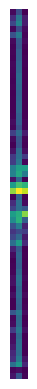

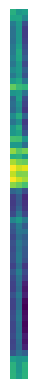

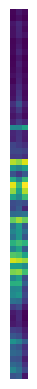

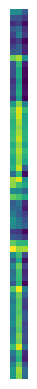

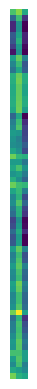

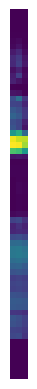

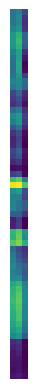

In [9]:

# 数据集目录
dataset_dir = '/content/Flower'


def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [64, 64])
    # image = tf.expand_dims(image, axis=0)
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1  # 归一化到[-1, 1]范围

    return image
# print(image.shape)

# 创建图像文件路径和标签的列表
image_paths = []

file_names = os.listdir(dataset_dir)
for filename in file_names:
    if filename.endswith('.jpg'):
        # 图像文件路径
        image_path = os.path.join(dataset_dir, filename)
        image_paths.append(image_path)


# Creating a data set
dataset = tf.data.Dataset.from_tensor_slices(image_paths)
images_dataset = dataset.map(load_and_preprocess_image)

# Get dataset size
dataset_size = len(image_paths)

# Splitting data sets
train_size = int(0.8 * dataset_size)  # the size of train is 80% of dataset
val_size = dataset_size - train_size  # the size of train is 20% of dataset

# Get dataset
train_datasets = images_dataset.take(train_size)
val_dataset = images_dataset.skip(train_size)

# Processing images
for example in train_datasets.take(7):
    image = example[4]
    plt.imshow(image.numpy())
    plt.axis('off')  # 去除坐标轴
    plt.show()


In [10]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [11]:
# Batch and shuffle the data

train_dataset = train_datasets.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [12]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model


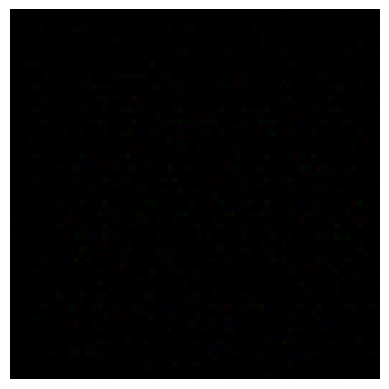

In [13]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])

generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, :])
plt.axis('off')
plt.show()



In [14]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [15]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00288798]], shape=(1, 1), dtype=float32)


In [16]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [18]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [20]:
checkpoint_dir = '/content'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [26]:
EPOCHS = 2000
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [27]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [28]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 100 epochs
    if (epoch + 1) % 100 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [29]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(np.clip(predictions[i, :, :, :] * 127.5 + 127.5, 0, 255).astype(np.uint8))
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

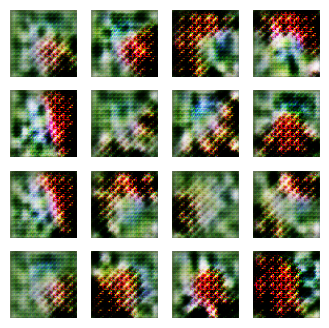

Time for epoch 1963 is 1.0280001163482666 sec


In [ ]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [31]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [32]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

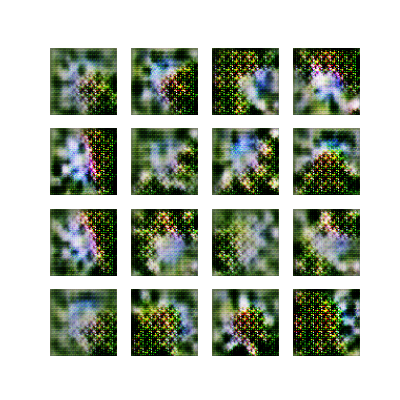

In [33]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [34]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-34-56bb6d34be2e>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-34-56bb6d34be2e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [35]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)